In [50]:
%load_ext blackcellmagic
import torch
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



In [ ]:
# ################## this is from lab4 homework, for exmaple. I did some work to play with model validation
# # import data 
# df_base = pd.read_csv("101821_lab4_FLIRcalibration.csv", skiprows=3)
# df_base = df_base[["direction", "temp_C", "cycle_1", "cycle_2"]]
# df_base = df_base.rename(columns={'cycle_1': '1', 'cycle_2':'2'})

# df_base = pd.melt(df_base, id_vars = ['temp_C', 'direction'], value_vars=list(df_base.columns)[2:],
# var_name="cycle", value_name='reading')

# print(df_base.shape)
# print(df_base.head())

# #### Ridge regression model
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold
# from sklearn.linear_model import Ridge

# # pandas to a numpy array
# data = df_base.values

# # reshape, add a dimension so it works in the model
# X, y = data[:, 0].reshape(-1, 1), data[:,-1].reshape(-1, 1)

# # define Ridge regression linear model
# lm = Ridge(alpha=1.0)

# # define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# #evaluate model
# scores = np.absolute(cross_val_score(lm, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1))
# print(f"Mean MAE: {np.mean(scores)} ({np.std(scores)})")

# # fit model
# lm.fit(X, y)

# # predictions
# y_pred = lm.predict(X)
# print(f"coeff: {lm.coef_}, intercept: {lm.intercept_}")

# # add to dataframe
# best_fit = pd.DataFrame({"temp_C":X.flatten(), "best_fit": y_pred.flatten()})


# # join column from best_fit into df
# df = df_base
# df["best_fit"] = best_fit.best_fit
# print(f"df_base + base_fit = {df.shape}\n{df.head()}")

# # create deviation
# # calculate deviation by subtracting the line value from the reading values for ALL data
# df["deviation"] = df.reading - df.best_fit
# #dev_df = create_dev_df(df)
# print(df.head())


In [ ]:

# create the model, sklearn.linear_model, Ridge Regression
# imposes a penalty on size of coefficients, improvement over Ordinary Least Squares
reg = linear_model.Ridge(alpha=0.5)
reg.fit(X_train, y_train)



In [51]:
######################################## Data import #########################################

# data path
df_path = (
    Path.cwd()
    / "data"
    / "processed"
    / "Jun22_2020"
    / "Jun22_2020_df.csv"
)

df = pd.read_csv(df_path).iloc[:, 2:]
print(df.head().iloc[:,0:4])


        yield  blue-blue-444  blue-green  blue-green-531
0  641.218827       0.013329   -0.419273       -0.445662
1  697.979880      -0.001042   -0.459447       -0.476955
2  709.891479       0.008540   -0.433216       -0.455423
3  674.191672       0.013697   -0.402593       -0.427173
4  680.430664       0.003195   -0.457388       -0.475037


In [52]:
# Test/Train/Val Split

# X and y
X = df.iloc[:, 1:].values
y = df['yield'].values

# train test Split (0.7/0.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=26, shuffle=True)

# test validate split (0.3 split into 0.15/0.15)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=26, shuffle=True)


# Standard scaling features
Standardization of features according to: x'=(x-µ)/ σ. Sets mean to 0 and unit variance to 1. <br>

Z-score Feature Scaling: https://developers.google.com/machine-learning/data-prep/transform/normalization

Greek symbols in ascii are produced like so:<br>
µ = Alt + 230 <br>
σ = Alt + 229 <br>
Φ = Alt + 232 <br>
<br>
https://www.keynotesupport.com/internet/special-characters-greek-letters-symbols.shtml

In [53]:
#  train the scaler ONLY on the training set. Then use it to scale train/test/val
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train) # trains the scaler using fit on X_train, then transforms X_train as well
X_test = scaler.transform(X_test) # no fit, transforms using data from fit() stored in the scaler
X_val = scaler.transform(X_val)

# convert variables to PyTorch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
print(X_train.shape)

torch.Size([40, 45])


In [55]:
# create the model, sklearn.linear_model, Ridge Regression
# imposes a penalty on size of coefficients, improvement over Ordinary Least Squares
reg = linear_model.Ridge(alpha=0.5)
reg.fit(X_train, y_train)

Ridge(alpha=0.5)

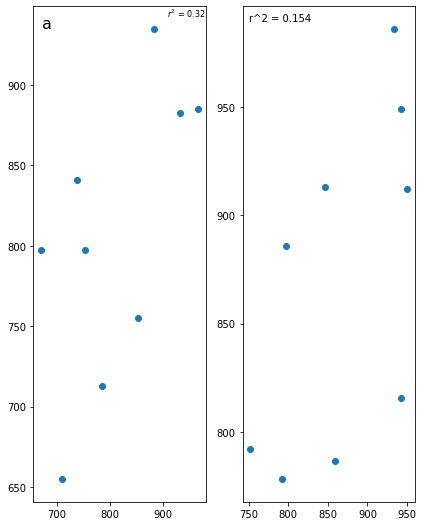

In [60]:
# test predictions
y_pred_t = reg.predict(X_test)
r2 = r2_score(y_test, y_pred_t)

# validation predictions
y_pred_v = reg.predict(X_val)
r2 = r2_score(y_val, y_pred_v)

# Display the images as one figure.
fig, axs = plt.subplots(1, 2)

axs[0].scatter(y_test, y_pred_t)
axs[0].annotate(
    "a",
    xy=(0.05, 0.98),
    xycoords="axes fraction",
    fontsize=16,
    horizontalalignment="left",
    verticalalignment="top",
)
axs[0].annotate(
    f"$r^2$ = {round(r2_score(y_test, y_pred_t), 2)}",
    xy=(1, 1),
    xycoords="axes fraction",
    fontsize=8,
    horizontalalignment="right",
    verticalalignment="top",
)


axs[1].scatter(y_val, y_pred_v)
axs[1].annotate("r^2 = {:.3f}".format(r2_score(y_val, y_pred_v)), (750, 990))

fig.tight_layout()
fig.set_figheight(8)